# PCA on selected data

The selected data is the result from the feature preparation and selection blog. 

## Relevant imports, read data

In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# read data that resulted from feature selection and preparation step. 
X_train = pd.read_table('X_train_reduced.csv', sep=',', header=0)
X_train.shape  # X_train has 297 features as the original dataset has been reduced in the feature selection blog.

(60816, 297)

## PCA

In [4]:
# normalize features to give them all equal importance and calculate principal components
# axis = 0, normalize each feature;  axis = 1, normalize each sample
X_train_normalized = normalize(X_train, axis=0)

pca = PCA(n_components = 0.8) # choose as many components as needed to get 80% cummulated variance.
X_train_projected = pca.fit_transform(X_train_normalized)
    
# verify variance ratio
print('...single variance ratio', pca.explained_variance_ratio_)
print('')
print('...cumulated variance ratio', np.cumsum(pca.explained_variance_ratio_))
print('')

/Users/claudine/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


...single variance ratio [ 0.08492847  0.06108077  0.04085054  0.03745848  0.03325938  0.03149763
  0.03053862  0.02744403  0.02578685  0.02234751  0.0193885   0.01927858
  0.01890549  0.01605571  0.01526489  0.01503946  0.01403141  0.0135135
  0.01342202  0.01237294  0.01198181  0.01183598  0.01174197  0.01145111
  0.01131386  0.01102682  0.01082885  0.01043657  0.01039511  0.01021189
  0.01008092  0.00974335  0.00935087  0.00885614  0.00852884  0.0081058
  0.00792807  0.0078044   0.00762969  0.00720601  0.00693169  0.00671253
  0.0064896   0.00641443  0.00618657  0.00613015  0.0056957   0.00566498
  0.00559392]

...cumulated variance ratio [ 0.08492847  0.14600924  0.18685978  0.22431826  0.25757764  0.28907527
  0.31961389  0.34705792  0.37284477  0.39519229  0.41458078  0.43385936
  0.45276486  0.46882057  0.48408546  0.49912492  0.51315633  0.52666983
  0.54009185  0.55246479  0.5644466   0.57628258  0.58802455  0.59947567
  0.61078953  0.62181635  0.6326452   0.64308177  0.653476

In [5]:
# read in Y_train for visualization reasons
Y_train = pd.read_table('Y_train.csv', sep=',', header=0)
Y_train = Y_train['TARGET']  # to get a 1d array for the random forest algorithm later on.

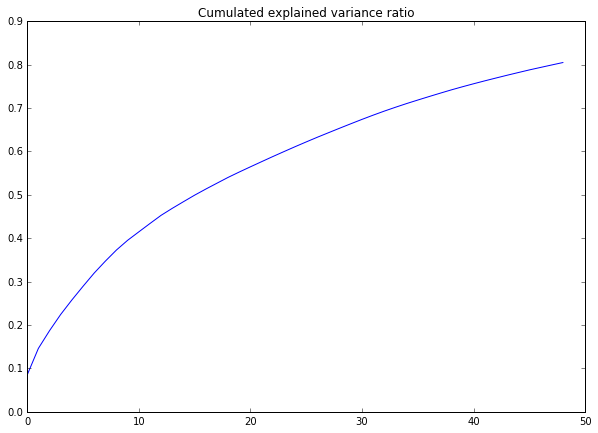

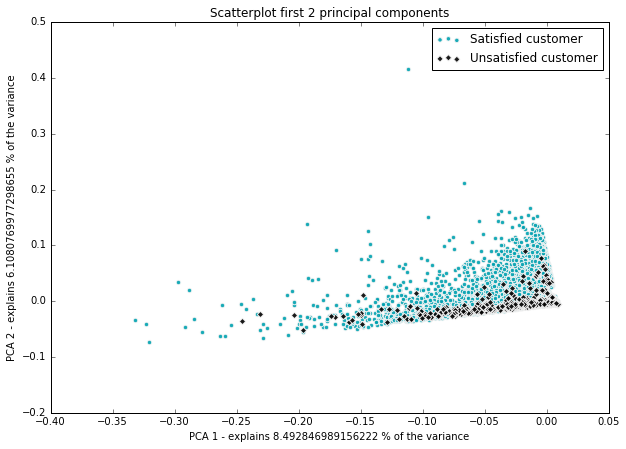

In [6]:
# plot cummulated explained variance ratio
fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,1,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulated explained variance ratio')

# plot first two pca results 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
    
classes = np.sort(np.unique(Y_train))
colors= [(0.0, 0.63, 0.69), 'black']
markers = ['o','D']
labels = ['Satisfied customer', 'Unsatisfied customer']
    
for class_ix, marker, color, label in zip(classes, markers, colors, labels):
    ax.scatter(X_train_projected[np.where(Y_train == class_ix), 0],
            X_train_projected[np.where(Y_train == class_ix), 1],
            marker = marker, color=color, edgecolor='whitesmoke', 
            linewidth='1', alpha=0.9, label = label)
    ax.legend(loc='best')
        
plt.title('Scatterplot first 2 principal components')
plt.xlabel('PCA 1 - explains {} % of the variance'.format(pca.explained_variance_ratio_[0] * 100.00))
plt.ylabel('PCA 2 - explains {} % of the variance'.format(pca.explained_variance_ratio_[1] * 100.00))
plt.show()

## Train model: Random forest on PCA data

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
clf = RandomForestClassifier(n_estimators=10)

# TRAIN
clf.fit(X_train_projected, Y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# read in valid data for performance evaluation
X_valid = pd.read_table('X_valid_reduced.csv', sep=',', header=0)
Y_valid = pd.read_table('Y_valid.csv', sep=',', header=0)

# normalize X_valid data
X_valid_normalized = normalize(X_valid, axis=0)

# apply pca transformation 
X_valid_projected = pca.transform(X_valid_normalized)

In [20]:
# PREDICT       
pred_labels = clf.predict(X_valid_projected)
pred_proba = clf.predict_proba(X_valid_projected)[:,1]

# EVALUATE
pred_score = clf.score(X_valid_projected, Y_valid)
print('... prediction score: {0:0.2f}%'.format(pred_score * 100))

... prediction score: 95.24%


## Confusion matrix on trained model

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
print(confusion_matrix(Y_valid, pred_labels))

[[14452   150]
 [  574    28]]


## ROC / AUC on trained model 

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

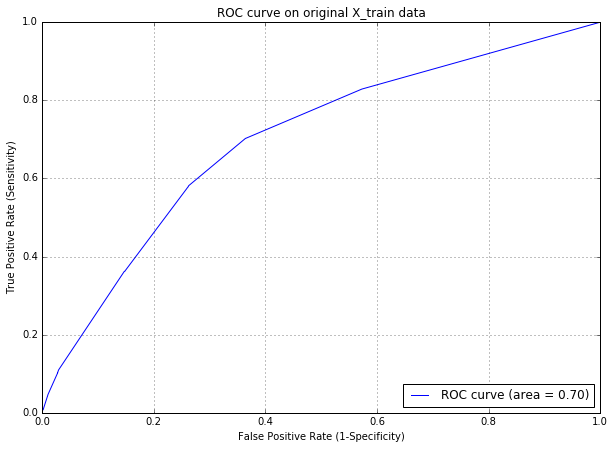

In [24]:
# calculate the false positive and true positive rates. 
# calculate the auc score

fpr, tpr, thresholds = roc_curve(Y_valid, pred_proba)
auc_score = roc_auc_score(Y_valid, pred_proba) 


# plot the roc curve
fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,1,1)    
    
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(auc_score))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve on original X_train data')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc='lower right')
print('')